<h1> Plotting routine to make simple plots showing location of granulaes

In [25]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
#import seaborn as sns
import pandas as pd
import h5py  
import s3fs
import readers as rd
import utils as ut
from glob import glob
# Use seaborn for nicer looking inline plots
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")



In [26]:
#selected files to plot
ATL03file='processed_ATL03_20190206145852_06130212_001_01.h5'
localFilePath='/home/jovyan/crackup/Outputs_selected/georgeVI/'+ATL03file

ATL03file2='processed_ATL03_20181015194309_02620112_001_01.h5'
localFilePath2='/home/jovyan/crackup/Outputs_selected/edgeworth/'+ATL03file2

#select beam
beamStr='gt1r'

In [27]:
def getATL03data(fileT, numpyout=False, beam='gt1r'):
    """ Pandas/numpy ATL03 reader
    Written by Alek Petty, June 2018 (alek.a.petty@nasa.gov)

    I've picked out the variables from ATL03 I think are of most interest to sea ice users, but by no
    means is this an exhastive list. 
    See the xarray or dictionary readers to load in the more complete ATL03 dataset
    or explore the hdf5 files themselves (I like using the app Panpoly for this) to see what else you
    might want
    
    Args:
        fileT (str): File path of the ATL03 dataset
        numpy (flag): Binary flag for outputting numpy arrays (True) or pandas dataframe (False)
        beam (str): ICESat-2 beam (the number is the pair, r=strong, l=weak)
        
    returns:
        either: select numpy arrays or a pandas dataframe

    """
    
    # Open the file
    try:
        ATL03 = h5py.File(fileT, 'r')
    except:
        'Not a valid file'
        
    lons=ATL03[beam+'/heights/lon_ph'][:]
    lats=ATL03[beam+'/heights/lat_ph'][:]
    
    #  Number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL03[beam+'/heights/delta_time'][:] 
    
    # #Add this value to delta time parameters to compute the full gps_seconds
    atlas_epoch=ATL03['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    # Conversion of delta_time to a calendar date
    # This function seems pretty convoluted but it works for now..
    # Sure there is a simpler functionw e can use here instead.
    temp = ut.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)
    
    # Express delta_time relative to start time of granule
    delta_time_granule=delta_time-delta_time[0]
    #delta_time_granule=delta_time
    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')
    
    dFtime=pd.DataFrame({'year':year, 'month':month, 'day':day, 
                        'hour':hour, 'minute':minute, 'second':second})
    
    
    # Primary variables of interest
    
    # Photon height
    heights=ATL03[beam+'/heights/h_ph'][:]
    #print(heights.shape)
    
    # Flag for signal confidence
    # column index:  0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    # values:
        #-- -1: Events not associated with a specific surface type
        #--  0: noise
        #--  1: buffer but algorithm classifies as background
        #--  2: low
        #--  3: medium
        #--  4: high
    signal_confidence=ATL03[beam+'/heights/signal_conf_ph'][:,3] 
    
    # Add photon rate, background rate etc to the reader here if we want
    
    ATL03.close()
    
    
    
    dF = pd.DataFrame({'heights':heights, 'lons':lons, 'lats':lats,
                       'signal_confidence':signal_confidence, 
                       'delta_time':delta_time_granule})
    
    # Add the datetime string
    dFtimepd=pd.to_datetime(dFtime)
    dF['datetime'] = pd.Series(dFtimepd, index=dF.index)
    
    # Filter out high elevation values 
    #dF = dF[(dF['signal_confidence']>2)]
    # Reset row indexing
    #dF=dF.reset_index(drop=True)
    return dF
    
    # Or return as numpy arrays 
    # return along_track_distance, heights

    

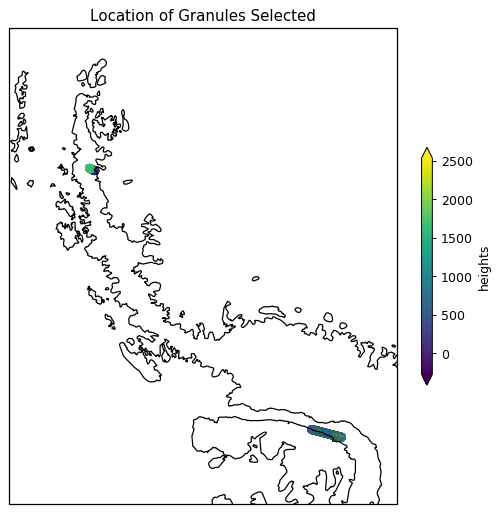

In [28]:
#read both files
dF03= getATL03data(localFilePath, beamStr)    # georgeVI
dF03_e= getATL03data(localFilePath2, beamStr)  #edgeworth

#plot

coast=shapereader.natural_earth(resolution='10m',category='physical',name='coastline')

coastlines=shapereader.Reader(coast).geometries()
# Generate a shorted version for mapping purposes
dF03short=dF03.iloc[::500, :]
dF03short.head(5)

dF03short_e=dF03_e.iloc[::500, :]
dF03short_e.head(5)
var='heights'

plt.figure(figsize=(7,7), dpi= 90)
# Make a new "NorthPolarStereo" projection instance
ax = plt.axes(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
plt.scatter(dF03short['lons'], dF03short['lats'],c=dF03short[var], cmap='viridis', transform=ccrs.PlateCarree())
plt.scatter(dF03short_e['lons'], dF03short_e['lats'],c=dF03short_e[var], cmap='viridis', transform=ccrs.PlateCarree())
#ax.coastlines()
ax.add_geometries(coastlines,ccrs.Geodetic(),edgecolor='k',facecolor='none')
#ax.drawmeridians()
plt.colorbar(label=var, shrink=0.5, extend='both')
plt.title('Location of Granules Selected')
# Limit the map to -60 degrees latitude and below.
ax.set_extent([-75, -50, -70, -65], ccrs.PlateCarree())